In [50]:
import pandas as pd
import re

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
import dotenv
import os

dotenv.load_dotenv()

True

In [51]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    code : Annotated[str, "Python Code"]

In [52]:
def create_title_summary(df):

    df_sampled = df.sample(n=5000) if len(df) > 5000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""                                          
            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
            )
    
    chain = prompt | llm
    
    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")
    
    return title, summary

In [53]:
class Discriminator(BaseModel):
    """
    주어진 데이터와 관련이 있는 정보인지 판단하고 분석을 할 준비를 진행합니다.
    데이터와 관련이 있는 질문이라면 "yes", 아니라면 "no"라고 답변하세요.
    """

    binary : Literal["yes", "no"] = Field(..., description="""Determine if the information is relevant to the given data and prepare for analysis.
Answer "yes" if the questions are related to the data, and "no" if the questions can only be answered with existing knowledge.""")

In [54]:
class Judge(BaseModel):
    """
    당신은 AI에이전트입니다.
    가지고 있는 도구는 아래와 같습니다.

    1. PythonAstREPLTool : 텍스트로 된 파이썬 코드를 실행시킬 수 있는 도구

    입력된 값을 기준으로 판단했을 때 도구를 실행시켜야하는 경우라면 'tool', 코드를 실행시키지 않아도 되는 경우에는 'llm'이라고 답변하세요.
    """

    select_tool : Literal["tool", "llm"] = Field(..., description="""You are the assistant in charge of determining the execution of the tool.
Answer 'tool' if you need to run the code and 'llm' if you don't.""")

In [55]:
file_path = "./data/titanic.csv"
df = pd.read_csv(file_path)

llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})    

In [56]:
title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [57]:
print("제목 : ", title)
print("요약 : ", summary)

제목 :  **타이타닉 생존자 데이터셋**
요약 :  이 데이터셋은 타이타닉 호의 승객 정보를 포함하고 있으며, 총 891명의 승객에 대한 다양한 특성을 기록하고 있습니다. 각 승객의 생존 여부(Survived), 객실 등급(Pclass), 이름(Name), 성별(Sex), 나이(Age), 형제자매 및 배우자 수(SibSp), 부모 및 자녀 수(Parch), 티켓 번호(Ticket), 요금(Fare), 객실(Cabin), 그리고 탑승 항구(Embarked) 등의 정보가 포함되어 있습니다. 이 데이터는 생존율 분석 및 다양한 인구 통계적 요인과의 관계를 연구하는 데 유용합니다.


In [58]:
discriminator = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Discriminator)

judge = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Judge)

In [113]:
def Discriminate(state:State):

    prompt = ChatPromptTemplate.from_messages([
        ("system","df : {df}"),
        ("human", "query : {query}")
    ])

    chain = prompt | discriminator

    result = chain.invoke({"df":df.head(),
                           "query":state["messages"][-1]}).binary
    
    global snapshot
    snapshot = result

    return result

In [114]:
def Judgement(state:State):

    prompt = ChatPromptTemplate.from_messages([
        ("system",""" 당신은 10년차 데이터 분석 전문가 및 해결사입니다.
                    질문의 결과를 위해 코드 실행이 필요한지 여부를 판단해야합니다.
                    그 판단을 위해 당신에겐 샘플 데이터가 주어집니다.
                    코드 실행이 필요하지 않다면 "llm"이라고 답변하세요.
                    하지만, 코드 실행을 해야한다면 "tool"을 반환합니다.
                    
                    ### 샘플 데이터
                    title : {title}
                    summary : {summary}
                    
                    df : {df}
                    ---

                """),
        ("human", "query : {query}")
    ])

    chain = prompt | judge

    result = chain.invoke({"title":title,
                            "summary":summary,
                            "df" : df.head(),
                            "query":state["messages"][-1]}).select_tool

    global snapshot
    snapshot = result

    return result

In [115]:
def create_code(state:State):
    
    prompt = ChatPromptTemplate([
        ("system", """당신은 pandas, matplotlib 라이브러리를 사용할 수 있는 전문가입니다. 주어진 df의 형태를 참고하여 코드를 작성합니다. \
                    다음은 `print(df.head())`의 형태입니다. {head}
        
                    ### 예시1
                    ```python
        
                    len(df)
                    ```
                    ### 예시2
                    ```python
        
                    # sum_gamerounds에 대한 히스토그램
                    plt.figure(figsize=(12, 6))
                    plt.barplot(df['sum_gamerounds'], bins=10, kde=True)
                    plt.title('Distribution of Sum Gamerounds')
                    plt.xlabel('Sum Gamerounds')
                    plt.ylabel('Frequency')
                    plt.grid()
                    plt.show()
                    ```
         
                    ### 주의할 점
                    1. seaborn은 사용하지 않습니다.
        
        """),
        ("human", "{query}")
    ])        
    
    chain = prompt | llm

    result = chain.invoke({
        "head" : df.head(),
        "query" : state["messages"][-1]
    }).content

    try:
        code = re.findall(r'```python\n(.*?)\n```', result, re.DOTALL)[0]

        return {"code" : code}
    except:
        return {"messages" : result,
                "code" : ""}

In [116]:
def execute_code(state:State):
    try:
        result = tool.invoke(state["code"])

        if result == "":
            pass
        else:
            return {"code":result}

        return state
    except:
        raise Exception("코드를 실행하지 못했습니다.")

In [117]:
def response(state:State):

    if snapshot == "no":
        prompt = ChatPromptTemplate([
            ("system", """이전 대화 기록을 첨부합니다.
                          답변에 참고하세요.
                          history : {messages}"""),
            ("user", "{query}")

        ])

        chain = prompt | llm
        answer = chain.invoke({"messages":state["messages"][:-1],
                             "query":state["messages"][-1]})
        
        return {"messages":answer}
    
    elif snapshot == "llm":
        prompt = ChatPromptTemplate([
            ("system", """ 당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             데이터셋의 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             df : {df}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "df" : df,
            "query" : state["messages"][-1]
        })

        return {"messages" : chain.invoke({"title" : title,
                                         "summary" : summary,
                                         "df" : df,
                                         "query" : state["messages"][-1]
                                          })
                                          }
    
    else:
        raise Exception("알 수 없는 응답입니다.")

In [118]:
def code_response(state:State):

    if state["code"] == "":
        prompt = ChatPromptTemplate([
            ("system", """ 당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             이전 답변과 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             답변 : {answer}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "answer" : state["messages"][:-1],
            "query" : state["messages"][-1]
        })

        return {"messages" : answer}

    else:
        prompt = ChatPromptTemplate([
            ("system", """
             
            아래의 코드와 제목, 요약을 참고하여 질의에 대해 답변합니다.
            절대 코드에 대해 설명하지마세요.
            독자는 프로그래머가 아닙니다.
            항상 출력되는 값을 기준으로 설명합니다.
            숫자가 매우 중요합니다. 숫자에 대한 정보를 잊지 마세요.
            데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요.

            제목 : {title}
            요약 : {summary}

            코드 : {code}
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm
        
        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "code" : state["code"],
            "query" : state["messages"][-1]
        })

        return {"messages" : answer}

In [119]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [120]:
def select(state:State):
    return state

In [121]:
graph_builder = StateGraph(State)

In [122]:
graph_builder.add_node("select", select)
graph_builder.add_node("create_code", create_code)
graph_builder.add_node("execute_code", execute_code)
graph_builder.add_node("response", response)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("pretty_print", pretty_print)


graph_builder.add_conditional_edges(START,
                                    Discriminate,
                                    {
                                    "yes":"select",
                                     "no":"response"
                                     }
                                     )
graph_builder.add_conditional_edges("select",
                                    Judgement,
                                    {
                                    "tool":"create_code",
                                     "llm":"response"
                                     }
                                     )
graph_builder.add_edge("create_code", "execute_code")
graph_builder.add_edge("execute_code", "code_response")
graph_builder.add_edge("code_response", "pretty_print")
graph_builder.add_edge("response", "pretty_print")
graph_builder.add_edge("pretty_print", END);

In [123]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

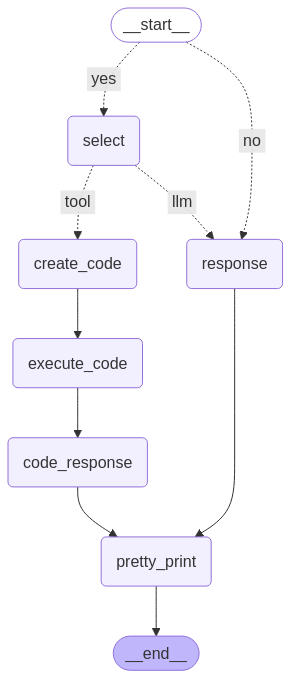

In [70]:
graph

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1054"})

In [72]:
result = graph.stream({"messages": ("user","생존자의 비율 시각화하고 인사이트 제공해줘.")}, config=config)



=== select ===


{'messages': [HumanMessage(content='생존자의 비율 시각화하고 인사이트 제공해줘.', additional_kwargs={}, response_metadata={}, id='adb98e78-a3c0-4081-b0e1-5d0c5f3949d8')]}


=== create_code ===


{'code': 'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 생존자와 비생존자의 수 계산\nsurvival_counts = df[\'Survived\'].value_counts()\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 8))\nplt.pie(survival_counts, labels=[\'Not Survived\', \'Survived\'], autopct=\'%1.1f%%\', startangle=90, colors=[\'#ff9999\',\'#66b3ff\'])\nplt.title(\'Survival Rate on the Titanic\')\nplt.axis(\'equal\')  # Equal aspect ratio ensures that pie chart is circular.\nplt.show()\n\n# 인사이트 제공\ntotal_passengers = len(df)\nsurvived_count = survival_counts[1]\nnot_survived_count = survival_counts[0]\n\nprint(f"Total Passengers: {total_passengers}")\nprint(f"Survived: {survived_count} ({(survived_count / total_passengers) * 100:.2f}%)")\nprint(f"Not Survived: {not_survived_count} ({(not_survived_count / total_passengers) * 100:.2f}

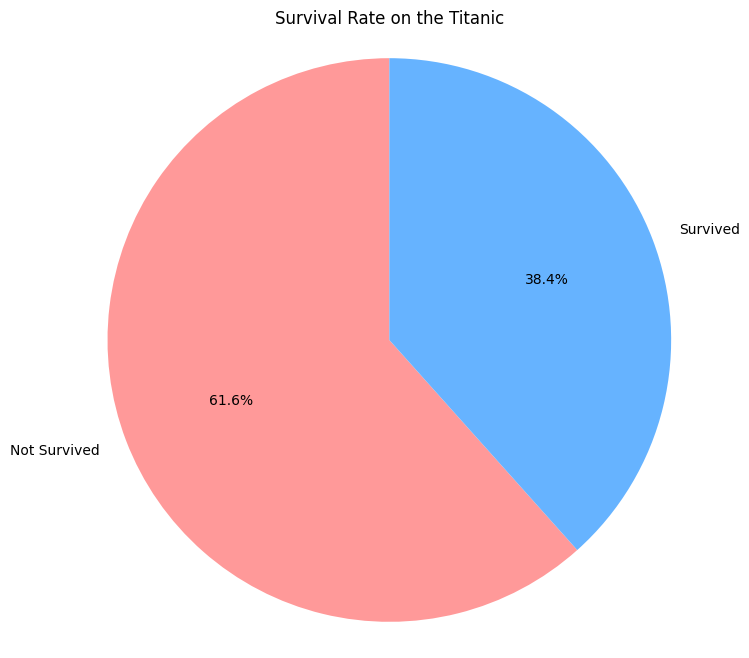

Total Passengers: 891
Survived: 342 (38.38%)


executre code의 else문을 지났습니다.


Not Survived: 549 (61.62%)



=== execute_code ===


{'messages': [HumanMessage(content='생존자의 비율 시각화하고 인사이트 제공해줘.', additional_kwargs={}, response_metadata={}, id='adb98e78-a3c0-4081-b0e1-5d0c5f3949d8')], 'code': 'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 생존자와 비생존자의 수 계산\nsurvival_counts = df[\'Survived\'].value_counts()\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 8))\nplt.pie(survival_counts, labels=[\'Not Survived\', \'Survived\'], autopct=\'%1.1f%%\', startangle=90, colors=[\'#ff9999\',\'#66b3ff\'])\nplt.title(\'Survival Rate on the Titanic\')\nplt.axis(\'equal\')  # Equal aspect ratio ensures that pie chart is circular.\nplt.show()\n\n# 인사이트 제공\ntotal_passengers = len(df)\nsurvived_count = survival_counts[1]\nnot_survived_count = survival_counts[0]\n\nprint(f"Total Passengers: {total_passengers}")\nprint(f"Survived: {survived_count} ({(survived_count / total_passengers) * 100:.2f}%)")\nprint(f"

In [73]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        try:
            print(v)
        except:   
            pass

In [74]:
result = graph.invoke({"messages":("user","아까 내가 질문했던 내용 다시 알려줘")}, config=config)



===== Result =====


당신이 아까 질문했던 내용은 "생존자의 비율 시각화하고 인사이트 제공해줘."였습니다. 이에 대한 답변으로, 타이타닉 생존자 데이터셋을 분석한 결과, 총 891명의 승객 중 생존자는 342명, 비생존자는 549명이며, 생존자의 비율은 약 38.34%로 나타났습니다. 비생존자의 비율은 약 61.66%입니다. 이 데이터는 생존율이 상대적으로 낮았음을 보여주며, 생존율을 높이기 위한 다양한 요인 분석이 중요하다는 인사이트를 제공했습니다.


In [75]:
result = graph.invoke({"messages":("user","아까 물어봤던 숫자들 다 더하면 몇인지 알려줘")}, config=config)



===== Result =====


아까 언급된 숫자들은 다음과 같습니다:

- 총 승객 수: 891명
- 생존자 수: 342명
- 비생존자 수: 549명

이 숫자들을 더하면:

891 + 342 + 549 = 1782

따라서, 총합은 1782입니다.


In [124]:
file_path = "./data/athlete_events.csv"
df = pd.read_csv(file_path)

tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})  

title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [125]:
print("제목 : ", title)
print()
print("요약 : ", summary)

제목 :  **올림픽 선수 데이터셋: 인구통계 및 경기 정보**

요약 :  이 데이터셋은 5000명의 올림픽 선수에 대한 정보를 포함하고 있으며, 각 선수의 ID, 이름, 성별, 나이, 신장, 체중, 소속 팀, 국가(NOC), 경기 연도 및 시즌, 개최 도시, 스포츠 종목, 이벤트, 그리고 메달 수상 여부를 기록하고 있습니다. 데이터는 여름 및 겨울 올림픽을 포함하며, 다양한 스포츠 종목에서의 선수들의 성과를 분석하는 데 유용합니다.


In [126]:
result = graph.invoke({"messages":("user", "이 데이터셋은 어떤 데이터셋이야?")}, config=config)



===== Result =====


이 데이터셋은 5000명의 올림픽 선수에 대한 정보를 포함하고 있습니다. 각 선수에 대한 데이터는 다음과 같은 항목을 포함합니다:

- ID: 선수의 고유 식별 번호
- Name: 선수의 이름
- Sex: 성별
- Age: 나이
- Height: 신장
- Weight: 체중
- Team: 소속 팀
- NOC: 국가 코드 (National Olympic Committee)
- Games: 올림픽 경기 연도 및 시즌 (여름 또는 겨울)
- Year: 개최 연도
- Season: 올림픽 시즌 (여름 또는 겨울)
- City: 개최 도시
- Sport: 스포츠 종목
- Event: 경기 이벤트
- Medal: 메달 수상 여부

이 데이터는 여름 및 겨울 올림픽을 포함하며, 다양한 스포츠 종목에서 선수들의 성과를 분석하는 데 유용합니다.


In [134]:
result = graph.invoke({"messages":("user", "가장 많이 출전한 나라는 어디야?")}, config=config)



===== Result =====


가장 많이 출전한 나라는 **USA**이며, 출전 횟수는 **18853회**입니다. 이는 USA가 올림픽에서 매우 활발하게 참여하고 있음을 나타냅니다.


In [111]:
df["NOC"].value_counts()

NOC
USA    18853
FRA    12758
GBR    12256
ITA    10715
GER     9830
       ...  
YMD        5
SSD        3
UNK        2
NBO        2
NFL        1
Name: count, Length: 230, dtype: int64

In [135]:
result = graph.invoke({"messages":("user", "그렇다면 두 번째로 많이 출전한 나라는 어디야?")}, config=config)



===== Result =====


두 번째로 많이 출전한 나라는 프랑스(FRA)이며, 출전 횟수는 12,758회입니다. 이는 프랑스가 올림픽에서 매우 활발하게 참여하고 있음을 나타냅니다.


In [154]:
result = graph.invoke({"messages":("user", "선수들의 평균 체중은 어떻게 돼?")}, config=config)



===== Result =====


선수들의 평균 체중은 70.70 kg입니다. 이는 5000명의 올림픽 선수들의 체중을 기반으로 한 값으로, 선수들의 신체적 특성을 이해하는 데 중요한 지표가 됩니다. 평균 체중이 특정 스포츠 종목이나 성별에 따라 어떻게 달라지는지를 분석하면, 각 종목에 적합한 신체 조건을 파악하는 데 도움이 될 수 있습니다.


In [148]:
df["Weight"].mean()

70.70239290053351

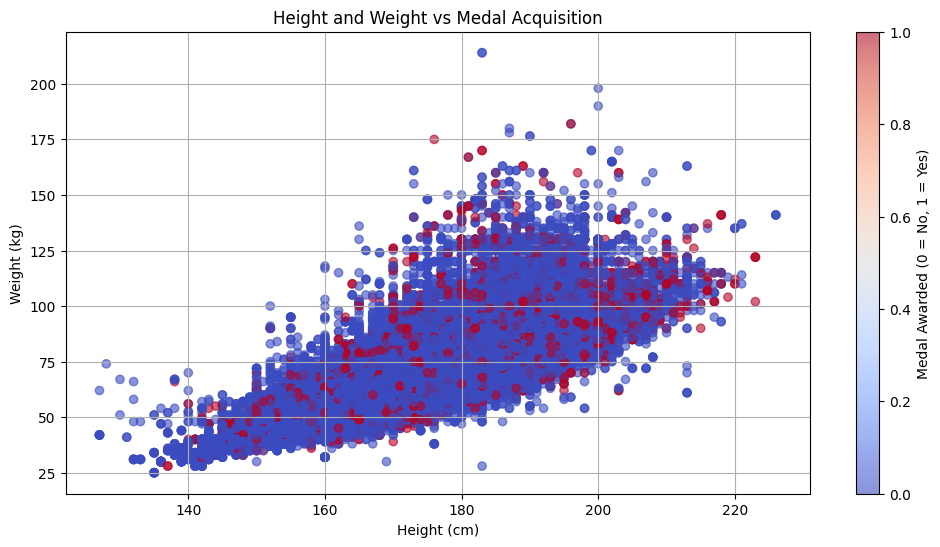



===== Result =====


이 분석에서는 선수들의 키와 체중이 메달 획득 여부와 어떤 관계가 있는지를 시각적으로 표현합니다. 

산점도 그래프를 통해 각 선수의 키(센티미터)와 체중(킬로그램)을 나타내며, 메달을 획득한 선수는 특정 색상으로 표시됩니다. 메달을 획득하지 않은 선수는 다른 색상으로 구분됩니다. 

이 그래프를 통해 몇 가지 인사이트를 얻을 수 있습니다:

1. **키와 체중의 분포**: 선수들의 키와 체중이 어떻게 분포되어 있는지 시각적으로 확인할 수 있습니다. 특정 범위의 키와 체중을 가진 선수들이 메달을 더 많이 획득하는 경향이 있을 수 있습니다.

2. **메달 획득의 경향**: 메달을 획득한 선수들이 특정한 키와 체중의 조합을 가지고 있는지, 또는 메달을 획득하지 않은 선수들과의 차이가 있는지를 분석할 수 있습니다.

이러한 시각적 분석은 선수들의 신체적 특성이 메달 성과에 미치는 영향을 이해하는 데 도움을 줄 수 있습니다.


In [163]:
result = graph.invoke({"messages":("user", "키와 체중, 그리고 메달 획득과의 상관관계를 보고 싶어. 그려줘")}, config=config)